In [4]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from timm import create_model

# 대상 이미지 6장 (정답 3 + 오답 3)
selected_images = [
    {"filename": "003.jpg", "true": "light", "pred": "light"},
    {"filename": "002.jpg", "true": "medium", "pred": "medium"},
    {"filename": "004.jpg", "true": "heavy", "pred": "heavy"},
    {"filename": "007.jpg", "true": "heavy", "pred": "light"},
    {"filename": "026.jpg", "true": "heavy", "pred": "medium"},
    {"filename": "019.jpg", "true": "light", "pred": "medium"},
]

# 경로 설정
img_dir = "./train_images"  # 필요 시 절대경로로 수정
save_dir = "./gradcam_outputs"
os.makedirs(save_dir, exist_ok=True)

# 모델 불러오기
model = create_model("regnety_002", pretrained=True)
model.eval()

# GradCAM 준비
cam_extractor = GradCAM(model)

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 시각화 진행
for item in selected_images:
    fname = item["filename"]
    img_path = os.path.join(img_dir, fname)

    # 이미지 불러오기
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    # Forward (gradient 필요)
    out = model(input_tensor)
    pred_class = out.squeeze(0).argmax().item()

    # Grad-CAM 맵 추출
    activation_map = cam_extractor(pred_class, out)[0]

    # 원본 이미지 복원
    input_image = to_pil_image(input_tensor.squeeze(0) * 0.5 + 0.5)

    # CAM 시각화
    cam_pil = to_pil_image(activation_map)
    result = overlay_mask(input_image, cam_pil, alpha=0.6)

    # 저장
    label = f"GT_{item['true']}_Pred_{item['pred']}"
    result.save(os.path.join(save_dir, f"{label}_{fname}"))

print("✅ Grad-CAM 시각화 완료. 결과는 'gradcam_outputs/' 폴더에 저장되었습니다.")


✅ Grad-CAM 시각화 완료. 결과는 'gradcam_outputs/' 폴더에 저장되었습니다.


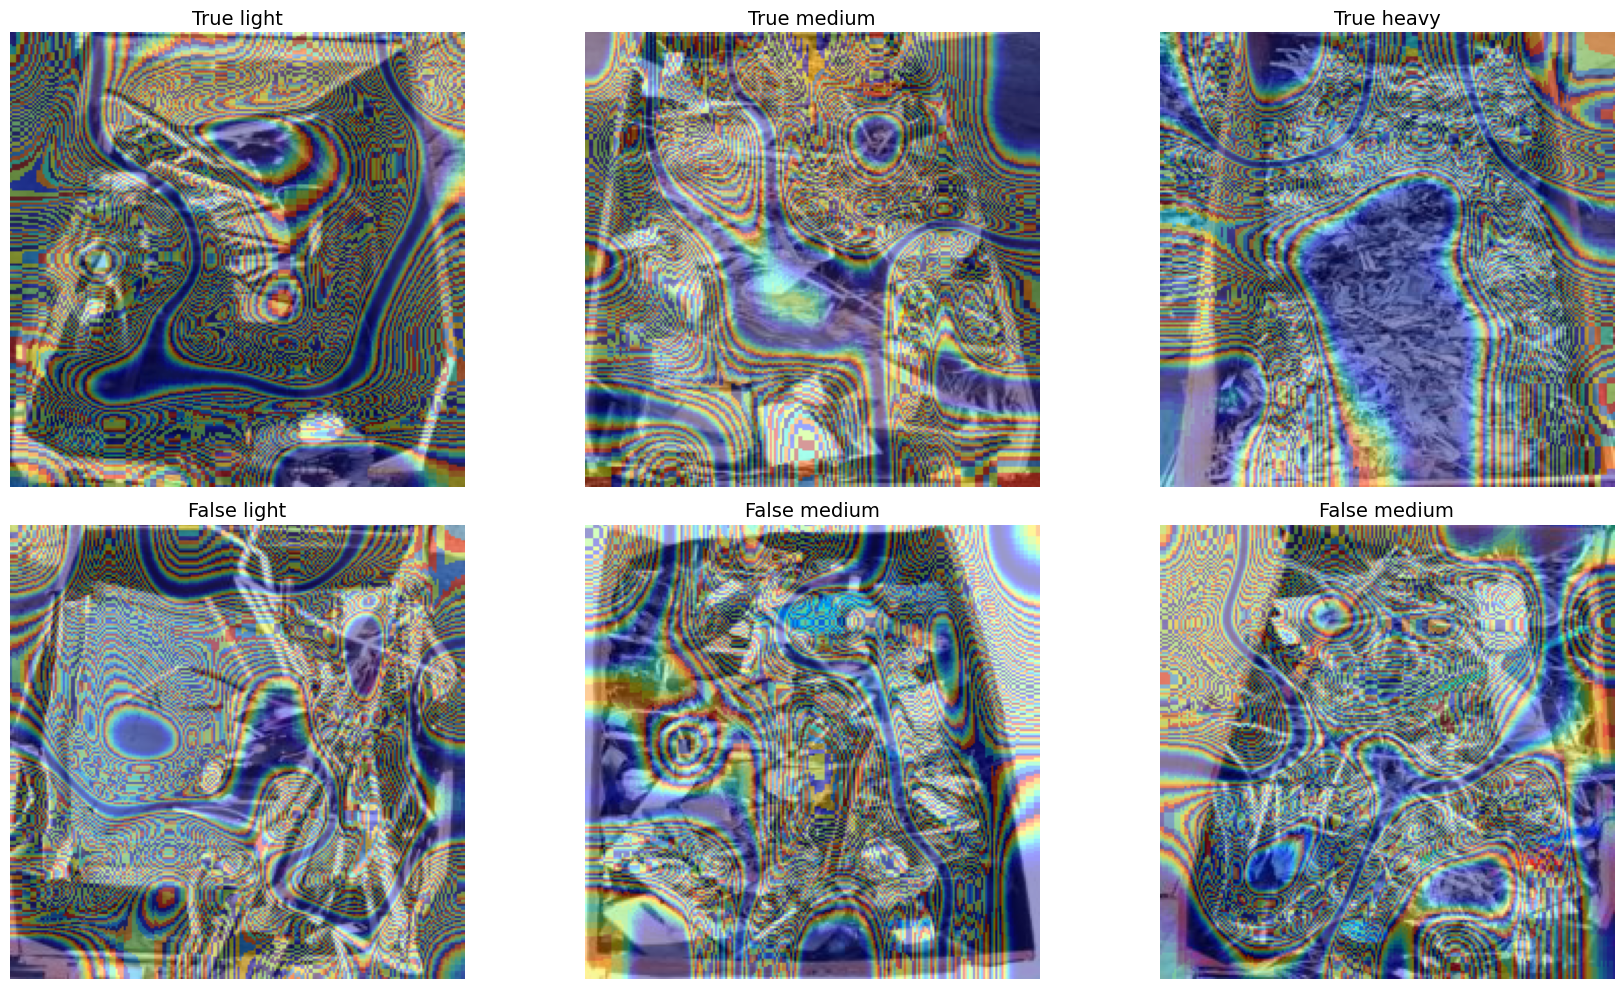

In [5]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from timm import create_model

# ⬇️ 이미지 정보 (정답/오답 포함)
selected_images = [
    {"filename": "003.jpg", "true": "light", "pred": "light"},
    {"filename": "002.jpg", "true": "medium", "pred": "medium"},
    {"filename": "004.jpg", "true": "heavy", "pred": "heavy"},
    {"filename": "007.jpg", "true": "heavy", "pred": "light"},
    {"filename": "026.jpg", "true": "heavy", "pred": "medium"},
    {"filename": "019.jpg", "true": "light", "pred": "medium"},
]

# ⬇️ 경로 설정 (필요 시 절대경로로 수정)
img_dir = "./train_images"

# ⬇️ 모델 설정 (CPU 강제 설정)
device = torch.device("cpu")
model = create_model("regnety_002", pretrained=True).to(device)
model.eval()

# ⬇️ Grad-CAM 설정
cam_extractor = GradCAM(model)

# ⬇️ 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ⬇️ 시각화 시작
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, item in enumerate(selected_images):
    fname = item["filename"]
    img_path = os.path.join(img_dir, fname)

    # 🔹 이미지 불러오기 및 전처리
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 🔹 예측
    out = model(input_tensor)
    pred_class = out.squeeze(0).argmax().item()

    # 🔹 CAM 맵 추출
    activation_map = cam_extractor(pred_class, out)[0].cpu()

    # 🔹 원본 이미지 복원
    input_image = to_pil_image(input_tensor.squeeze(0).cpu() * 0.5 + 0.5)

    # 🔹 CAM 시각화 및 Overlay
    cam_pil = to_pil_image(activation_map)
    result = overlay_mask(input_image, cam_pil, alpha=0.6)

    # 🔹 표시
    label_prefix = "True" if item["true"] == item["pred"] else "False"
    axes[idx].imshow(result)
    axes[idx].axis("off")
    axes[idx].set_title(f"{label_prefix} {item['pred']}", fontsize=14)

plt.tight_layout()
plt.show()
